# **CS224W - Colab 1**

In this Colab, we will write a full pipeline for **learning node embeddings**.
We will go through the following 3 steps.

To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

We will then work together to transform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.

Finally, we will finish the first learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk / node2vec algorithms taught in the lecture. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

Now let's get started!

**Note**: Make sure to **sequentially run all the cells**, so that the intermediate variables / packages will carry over to the next cell

# 1 Graph Basics
To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

## Setup
We will heavily use NetworkX in this Colab.

In [315]:
import networkx as nx

## Zachary's karate club network

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

In [316]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

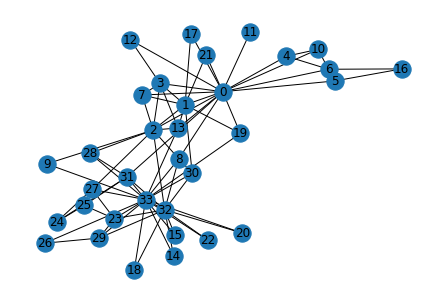

In [317]:
# Visualize the graph
nx.draw(G, with_labels = True)

## Question 1: What is the average degree of the karate club network? (5 Points)

In [318]:
def average_degree(num_edges, num_nodes):
  avg_degree = 2 * num_edges / num_nodes
  avg_degree = round(avg_degree)
  return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: What is the average clustering coefficient of the karate club network? (5 Points)

In [319]:
def average_clustering_coefficient(G):
  avg_cluster_coef = nx.average_clustering(G)
  avg_cluster_coef = round(avg_cluster_coef, 2)
  return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration? (5 Points)

Please complete the code block by implementing the PageRank equation: $r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$

In [320]:
def one_iter_pagerank(G, beta, r0, node_id):
    r1 = 0
    for neighbor_id in G.neighbors(node_id):
        r1 += beta * r0 / G.degree[neighbor_id]
    r1 += (1 - beta) / G.number_of_nodes()
    r1 = round(r1, 2)
    return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


## Question 4: What is the (raw) closeness centrality for the karate club network node 5? (5 Points)

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [321]:
def closeness_centrality(G, node=5):
  closeness = nx.closeness_centrality(G, u=node)  # normailized result
  closeness /= len(nx.node_connected_component(G, node)) - 1 # unnormalized result

  closeness = round(closeness, 2)
  return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The karate club network has closeness centrality {}".format(closeness))

The karate club network has closeness centrality 0.01


# 2 Graph to Tensor
We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [322]:
import torch
print(torch.__version__)

1.10.2


## Question 5: Getting the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor? (10 Points)

In [323]:
def graph_to_edge_list(G):
  edge_list = [e for e in G.edges]

  return edge_list

def edge_list_to_tensor(edge_list):
  edge_index = torch.tensor(edge_list)
  
  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([78, 2])
The pos_edge_index tensor has sum value 2535


## Question 6: Please implement following function that samples negative edges. Then you will answer which edges (edge_1 to edge_5) can be negative ones in the karate club network? (10 Points)

In [324]:
import random

def sample_negative_edges(G, num_neg_samples):
  neg_edge_list = []
  count = 0

  while True:
    n1 = random.randint(0, G.number_of_nodes() - 1)
    n2 = random.randint(0, G.number_of_nodes() - 1)
    if n1 == n2 or (n1, n2) in G.edges or (n2, n1) in G.edges:
      continue
    if (n1, n2) in neg_edge_list or (n2, n1) in neg_edge_list:
      continue
    neg_edge_list.append((n1, n2))

    count += 1
    if count == num_neg_samples:
      break
  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

edges = [edge_1, edge_2, edge_3, edge_4, edge_5]
for e in edges:
  if not (e in G.edges or tuple(reversed(e)) in G.edges):
    print(f'{e} can be negative ones')

The neg_edge_index tensor has shape torch.Size([78, 2])
(1, 33) can be negative ones
(4, 2) can be negative ones


In [325]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [326]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.10.2


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [327]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [328]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-0.5956,  1.1019,  0.5539, -0.9509, -0.5039,  1.7359,  1.1365,  0.7353]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.5956,  1.1019,  0.5539, -0.9509, -0.5039,  1.7359,  1.1365,  0.7353],
        [-0.4999,  0.0399, -0.7815,  0.3195,  0.8211,  0.8643,  0.4917,  0.4454]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [329]:
# Please do not change / reset the random seed
# torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  emb = nn.Embedding(num_node, embedding_dim)
  
  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[-0.8873,  0.5298,  0.2684,  0.3501, -0.2723,  1.0666, -0.8953,  1.4148,
         -0.9173,  0.8372,  1.4950, -0.8303, -1.9901, -0.8779,  0.2204, -1.9548],
        [-1.8470, -0.5632, -0.2931, -1.5726, -1.0080, -1.1255,  2.0840,  0.2845,
         -0.2090,  2.7949,  0.9469,  1.1613,  0.0216,  2.1849,  0.3705,  0.8323]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then visualize each point, colored by the community it belongs to.

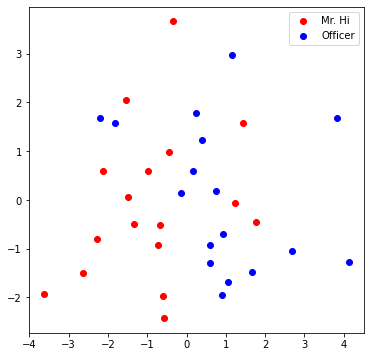

In [330]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: Training the embedding! What is the best performance you can get? Please report both the best loss and accuracy on Gradescope. (20 Points)

In [331]:
from torch.optim import SGD

def accuracy(pred, label):
  pred = torch.round(pred)
  acc = torch.sum(pred.flatten() == label.flatten()) / pred.shape[0] / 2

  return acc

def train(emb, loss_fn, sigmoid, train_label, train_edge):

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for epoch in range(epochs):
    optimizer.zero_grad()
    node_embed = emb(train_edge)
    dot_product1 = torch.sum(node_embed[:, 0, :] * node_embed[:, 1, :], -1)
    dot_product2 = torch.sum(node_embed[:, 2, :] * node_embed[:, 3, :], -1)
    dot_product = torch.cat((dot_product1.reshape(-1, 1), dot_product2.reshape(-1, 1)), dim=1)
    result = torch.nn.functional.sigmoid(dot_product)
    loss = loss_fn(result, train_label)
    acc = accuracy(result, train_label)
    loss.backward()
    optimizer.step()
    print(f'epoch:{epoch}, loss:{loss}, acc:{acc}')

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# Generate the positive and negative labels
train_label = torch.tensor([1, 0], dtype=torch.float32).repeat(78, 1)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

epoch:0, loss:1.617380976676941, acc:0.5769230723381042
epoch:1, loss:1.607048749923706, acc:0.5833333134651184
epoch:2, loss:1.5875988006591797, acc:0.5833333134651184
epoch:3, loss:1.5600695610046387, acc:0.5833333134651184
epoch:4, loss:1.525669813156128, acc:0.5833333134651184
epoch:5, loss:1.4854412078857422, acc:0.5961538553237915
epoch:6, loss:1.440359115600586, acc:0.5961538553237915
epoch:7, loss:1.3913822174072266, acc:0.5961538553237915
epoch:8, loss:1.3393878936767578, acc:0.6025640964508057
epoch:9, loss:1.285152792930603, acc:0.6089743375778198
epoch:10, loss:1.2294684648513794, acc:0.6153846383094788
epoch:11, loss:1.1729971170425415, acc:0.6217948794364929
epoch:12, loss:1.116342544555664, acc:0.6217948794364929
epoch:13, loss:1.060104250907898, acc:0.6410256624221802
epoch:14, loss:1.004765272140503, acc:0.6666666865348816
epoch:15, loss:0.9507777690887451, acc:0.6794871687889099
epoch:16, loss:0.8985005021095276, acc:0.692307710647583
epoch:17, loss:0.8482095003128052

/Users/wangyingbo/opt/anaconda3/envs/python380/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:79, loss:0.08327853679656982, acc:0.9935897588729858
epoch:80, loss:0.0818864032626152, acc:0.9935897588729858
epoch:81, loss:0.08053866773843765, acc:0.9935897588729858
epoch:82, loss:0.07923294603824615, acc:0.9935897588729858
epoch:83, loss:0.07796705514192581, acc:0.9935897588729858
epoch:84, loss:0.07673902064561844, acc:0.9935897588729858
epoch:85, loss:0.07554708421230316, acc:0.9935897588729858
epoch:86, loss:0.07438961416482925, acc:0.9935897588729858
epoch:87, loss:0.07326511293649673, acc:0.9935897588729858
epoch:88, loss:0.07217218726873398, acc:0.9935897588729858
epoch:89, loss:0.07110954821109772, acc:0.9935897588729858
epoch:90, loss:0.07007598876953125, acc:0.9935897588729858
epoch:91, loss:0.06907036900520325, acc:0.9935897588729858
epoch:92, loss:0.06809161603450775, acc:0.9935897588729858
epoch:93, loss:0.06713872402906418, acc:0.9935897588729858
epoch:94, loss:0.06621071696281433, acc:1.0
epoch:95, loss:0.06530668586492538, acc:1.0
epoch:96, loss:0.06442573666

## Visualize the final node embeddings
Visualize your final embedding here! 
You can visually compare the figure with the previous embedding figure. 
After training, you should oberserve that the two classes are more evidently separated. 
This is a great sanitity check for your implementation as well.

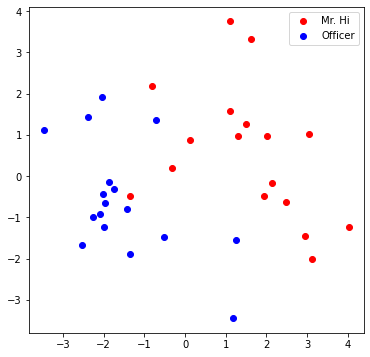

In [332]:
# Visualize the final learned embedding
visualize_emb(emb)